In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import pickle
from tqdm import tqdm
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

2025-02-24 04:21:24.967820: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 04:21:24.975621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740351084.985220   35390 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740351084.987917   35390 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 04:21:24.997393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import pickle
from tqdm import tqdm

# ✅ Force TensorFlow to run on CPU (Prevents GPU memory usage)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load YAMNet model
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Paths
DATA_DIR = "Datasets"
SAVE_PATH = "preprocessed_data.pkl"
CLASS_MAPPING = {"Cry": 0, "Screaming": 1, "NotScreaming": 2}

# Function to extract embeddings from audio
def extract_embedding(file_path):
    waveform, sr = librosa.load(file_path, sr=16000)
    waveform = waveform.astype(np.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    tf.keras.backend.clear_session()  # ✅ Free memory
    return np.mean(embeddings.numpy(), axis=0)

# Process dataset
data, labels = [], []
for label in CLASS_MAPPING.keys():
    folder_path = os.path.join(DATA_DIR, label)
    for file in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        file_path = os.path.join(folder_path, file)
        try:
            embedding = extract_embedding(file_path)
            data.append(embedding)
            labels.append(CLASS_MAPPING[label])
        except Exception as e:
            print(f"Skipping {file}: {e}")

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Save preprocessed data
with open(SAVE_PATH, "wb") as f:
    pickle.dump((data, labels), f)

print(f"✅ Preprocessing complete. Data saved to {SAVE_PATH}.")


2025-02-24 04:22:30.419519: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-02-24 04:22:30.419536: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: administrator-B760M-DS3H-DDR4
2025-02-24 04:22:30.419539: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: administrator-B760M-DS3H-DDR4
2025-02-24 04:22:30.419623: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2025-02-24 04:22:30.419633: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2025-02-24 04:22:30.419635: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


In [2]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed data
SAVE_PATH = "preprocessed_data.pkl"
with open(SAVE_PATH, "rb") as f:
    data, labels = pickle.load(f)

# Split into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save splits
split_data = {"train": (X_train, y_train), "valid": (X_valid, y_valid), "test": (X_test, y_test)}
with open("train_valid_test.pkl", "wb") as f:
    pickle.dump(split_data, f)

print(f"✅ Data split complete. Saved to 'train_valid_test.pkl'.")
print(f"Train: {len(X_train)}, Valid: {len(X_valid)}, Test: {len(X_test)}")


✅ Data split complete. Saved to 'train_valid_test.pkl'.
Train: 2765, Valid: 592, Test: 593


In [3]:
import tensorflow as tf
import pickle
import numpy as np
from tqdm import tqdm

# Load train and validation data
with open("train_valid_test.pkl", "rb") as f:
    data_splits = pickle.load(f)

X_train, y_train = data_splits["train"]
X_valid, y_valid = data_splits["valid"]

NUM_CLASSES = 3  # Cry, Scream, Normal

# Define a simple classifier model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input shape from YAMNet embeddings
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")  # 3 classes
])

# Compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Custom tqdm callback for progress display
class TQDMCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_progress = tqdm(total=self.params['steps'], 
                                   desc=f"Epoch {epoch+1}/{self.params['epochs']}", 
                                   unit="batch")

    def on_batch_end(self, batch, logs=None):
        self.epoch_progress.update(1)
        self.epoch_progress.set_postfix(loss=logs.get('loss'), acc=logs.get('accuracy'))

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_progress.close()
        print(f"Epoch {epoch+1} - Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, "
              f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

# Train model and save history
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=16, 
    validation_data=(X_valid, y_valid), 
    callbacks=[TQDMCallback()],
)

# Save training history
with open("train_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Save trained model
model.save("yamnet_finetuned.h5")

print("✅ Training complete. Model saved as 'yamnet_finetuned.h5'.")


Epoch 1/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 1/20


Epoch 1/20:   1%|          | 1/173 [00:00<00:55,  3.10batch/s, acc=0.25, loss=1.22]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - accuracy: 0.2500 - loss: 1.2246

Epoch 1/20:  18%|█▊        | 32/173 [00:00<00:45,  3.10batch/s, acc=0.779, loss=0.603]

 32/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6700 - loss: 0.8042   

Epoch 1/20:  34%|███▎      | 58/173 [00:00<00:00, 176.34batch/s, acc=0.807, loss=0.514]

 58/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7267 - loss: 0.6877

Epoch 1/20:  52%|█████▏    | 90/173 [00:00<00:00, 176.34batch/s, acc=0.826, loss=0.457]

 90/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7588 - loss: 0.6168

Epoch 1/20:  75%|███████▍  | 129/173 [00:00<00:00, 332.27batch/s, acc=0.85, loss=0.412] 

129/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7830 - loss: 0.5617

Epoch 1/20:  88%|████████▊ | 152/173 [00:00<00:00, 332.27batch/s, acc=0.856, loss=0.398]

152/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7935 - loss: 0.5381

Epoch 1/20: 100%|██████████| 173/173 [00:00<00:00, 244.19batch/s, acc=0.861, loss=0.385]


Epoch 1 - Loss: 0.3846, Accuracy: 0.8611, Val Loss: 0.3489, Val Accuracy: 0.8936
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8018 - loss: 0.5191 - val_accuracy: 0.8936 - val_loss: 0.3489


Epoch 2/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 2/20


Epoch 2/20:   1%|          | 1/173 [00:00<00:02, 77.72batch/s, acc=0.938, loss=0.182]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9375 - loss: 0.1821

Epoch 2/20:  16%|█▌        | 27/173 [00:00<00:00, 428.43batch/s, acc=0.896, loss=0.259]

 27/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8928 - loss: 0.2785 

Epoch 2/20:  34%|███▎      | 58/173 [00:00<00:00, 457.76batch/s, acc=0.895, loss=0.264]

 58/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8951 - loss: 0.2671

Epoch 2/20:  53%|█████▎    | 91/173 [00:00<00:00, 457.76batch/s, acc=0.9, loss=0.258]  

 91/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8960 - loss: 0.2640

Epoch 2/20:  63%|██████▎   | 109/173 [00:00<00:00, 520.46batch/s, acc=0.898, loss=0.261]

109/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8965 - loss: 0.2636

Epoch 2/20:  86%|████████▌ | 149/173 [00:00<00:00, 520.46batch/s, acc=0.9, loss=0.267]  

149/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8973 - loss: 0.2638

Epoch 2/20: 100%|██████████| 173/173 [00:00<00:00, 490.95batch/s, acc=0.9, loss=0.27]   

Epoch 2 - Loss: 0.2702, Accuracy: 0.9002, Val Loss: 0.2724, Val Accuracy: 0.9003
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8976 - loss: 0.2645 - val_accuracy: 0.9003 - val_loss: 0.2724



Epoch 3/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 3/20


Epoch 3/20:   1%|          | 1/173 [00:00<00:02, 84.88batch/s, acc=0.875, loss=0.26]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8750 - loss: 0.2600

Epoch 3/20:  20%|██        | 35/173 [00:00<00:00, 549.18batch/s, acc=0.905, loss=0.245]

 35/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8982 - loss: 0.2758 

Epoch 3/20:  39%|███▉      | 68/173 [00:00<00:00, 593.76batch/s, acc=0.899, loss=0.268]

 68/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8993 - loss: 0.2654

Epoch 3/20:  51%|█████     | 88/173 [00:00<00:00, 593.76batch/s, acc=0.901, loss=0.266]

 88/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8995 - loss: 0.2659

Epoch 3/20:  73%|███████▎  | 126/173 [00:00<00:00, 573.51batch/s, acc=0.908, loss=0.26] 

126/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9008 - loss: 0.2682

Epoch 3/20:  94%|█████████▍| 163/173 [00:00<00:00, 573.51batch/s, acc=0.908, loss=0.261]

163/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9026 - loss: 0.2658

Epoch 3/20: 100%|██████████| 173/173 [00:00<00:00, 482.59batch/s, acc=0.909, loss=0.258]


Epoch 3 - Loss: 0.2580, Accuracy: 0.9089, Val Loss: 0.3004, Val Accuracy: 0.9105
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9030 - loss: 0.2653 - val_accuracy: 0.9105 - val_loss: 0.3004


Epoch 4/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 4/20


Epoch 4/20:   1%|          | 1/173 [00:00<00:02, 75.14batch/s, acc=0.938, loss=0.19]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9375 - loss: 0.1897

Epoch 4/20:  19%|█▉        | 33/173 [00:00<00:00, 518.76batch/s, acc=0.917, loss=0.293]

 33/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9212 - loss: 0.2893 

Epoch 4/20:  40%|████      | 70/173 [00:00<00:00, 581.71batch/s, acc=0.913, loss=0.259]

 70/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9137 - loss: 0.2862

Epoch 4/20:  55%|█████▌    | 96/173 [00:00<00:00, 581.71batch/s, acc=0.919, loss=0.24] 

 96/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9141 - loss: 0.2758

Epoch 4/20:  77%|███████▋  | 133/173 [00:00<00:00, 616.82batch/s, acc=0.915, loss=0.25] 

133/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9158 - loss: 0.2667

Epoch 4/20:  96%|█████████▌| 166/173 [00:00<00:00, 616.82batch/s, acc=0.913, loss=0.253]

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9153 - loss: 0.2641

Epoch 4/20: 100%|██████████| 173/173 [00:00<00:00, 521.29batch/s, acc=0.913, loss=0.252]

Epoch 4 - Loss: 0.2520, Accuracy: 0.9128, Val Loss: 0.3189, Val Accuracy: 0.9088
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9152 - loss: 0.2636 - val_accuracy: 0.9088 - val_loss: 0.3189



Epoch 5/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 5/20


Epoch 5/20:   1%|          | 1/173 [00:00<00:02, 67.65batch/s, acc=0.688, loss=0.719]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6875 - loss: 0.7192

Epoch 5/20:  23%|██▎       | 39/173 [00:00<00:00, 590.22batch/s, acc=0.902, loss=0.251]

 39/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8923 - loss: 0.2949 

Epoch 5/20:  34%|███▎      | 58/173 [00:00<00:00, 503.91batch/s, acc=0.907, loss=0.247]

 58/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8969 - loss: 0.2803

Epoch 5/20:  51%|█████     | 88/173 [00:00<00:00, 503.91batch/s, acc=0.913, loss=0.232]

 88/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9016 - loss: 0.2666

Epoch 5/20:  71%|███████   | 122/173 [00:00<00:00, 571.75batch/s, acc=0.92, loss=0.219] 

122/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9063 - loss: 0.2537

Epoch 5/20:  78%|███████▊  | 135/173 [00:00<00:00, 571.75batch/s, acc=0.921, loss=0.216]

135/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9076 - loss: 0.2505

Epoch 5/20: 100%|██████████| 173/173 [00:00<00:00, 449.72batch/s, acc=0.919, loss=0.218]

Epoch 5 - Loss: 0.2181, Accuracy: 0.9193, Val Loss: 0.2706, Val Accuracy: 0.9088
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9107 - loss: 0.2428 - val_accuracy: 0.9088 - val_loss: 0.2706



Epoch 6/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 6/20


Epoch 6/20:   1%|          | 1/173 [00:00<00:02, 81.26batch/s, acc=1, loss=0.0484]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0484

Epoch 6/20:  11%|█         | 19/173 [00:00<00:00, 298.18batch/s, acc=0.938, loss=0.218]

 19/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9428 - loss: 0.2186 

Epoch 6/20:  32%|███▏      | 56/173 [00:00<00:00, 436.88batch/s, acc=0.923, loss=0.212]

 56/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 0.2130

Epoch 6/20:  57%|█████▋    | 99/173 [00:00<00:00, 436.88batch/s, acc=0.922, loss=0.219]

 99/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2129

Epoch 6/20:  75%|███████▌  | 130/173 [00:00<00:00, 633.79batch/s, acc=0.923, loss=0.211]

130/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9264 - loss: 0.2138

Epoch 6/20:  88%|████████▊ | 152/173 [00:00<00:00, 633.79batch/s, acc=0.925, loss=0.206]

152/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9261 - loss: 0.2129

Epoch 6/20: 100%|██████████| 173/173 [00:00<00:00, 502.34batch/s, acc=0.924, loss=0.204]

Epoch 6 - Loss: 0.2039, Accuracy: 0.9244, Val Loss: 0.2395, Val Accuracy: 0.9088
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9260 - loss: 0.2118 - val_accuracy: 0.9088 - val_loss: 0.2395



Epoch 7/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 7/20


Epoch 7/20:   1%|          | 1/173 [00:00<00:02, 72.73batch/s, acc=1, loss=0.0391]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0391

Epoch 7/20:  23%|██▎       | 40/173 [00:00<00:00, 623.21batch/s, acc=0.92, loss=0.194] 

 40/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9272 - loss: 0.1598 

Epoch 7/20:  42%|████▏     | 72/173 [00:00<00:00, 678.70batch/s, acc=0.928, loss=0.192]

 72/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9275 - loss: 0.1730

Epoch 7/20:  61%|██████    | 105/173 [00:00<00:00, 678.70batch/s, acc=0.933, loss=0.184]

105/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9290 - loss: 0.1774

Epoch 7/20:  80%|███████▉  | 138/173 [00:00<00:00, 643.72batch/s, acc=0.935, loss=0.179]

138/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9302 - loss: 0.1785

Epoch 7/20:  97%|█████████▋| 167/173 [00:00<00:00, 643.72batch/s, acc=0.935, loss=0.179]

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9313 - loss: 0.1783

Epoch 7/20: 100%|██████████| 173/173 [00:00<00:00, 534.89batch/s, acc=0.934, loss=0.183]


Epoch 7 - Loss: 0.1833, Accuracy: 0.9338, Val Loss: 0.2693, Val Accuracy: 0.9122
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 0.1785 - val_accuracy: 0.9122 - val_loss: 0.2693


Epoch 8/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 8/20


Epoch 8/20:   1%|          | 1/173 [00:00<00:02, 74.70batch/s, acc=1, loss=0.0314]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0314

Epoch 8/20:  13%|█▎        | 23/173 [00:00<00:00, 357.08batch/s, acc=0.948, loss=0.137]

 23/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.1085 

Epoch 8/20:  36%|███▌      | 62/173 [00:00<00:00, 515.16batch/s, acc=0.939, loss=0.167]

 62/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9522 - loss: 0.1385

Epoch 8/20:  58%|█████▊    | 101/173 [00:00<00:00, 515.16batch/s, acc=0.93, loss=0.191]

101/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9451 - loss: 0.1529

Epoch 8/20:  70%|██████▉   | 121/173 [00:00<00:00, 574.90batch/s, acc=0.926, loss=0.2]  

121/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - loss: 0.1596

Epoch 8/20:  92%|█████████▏| 160/173 [00:00<00:00, 574.90batch/s, acc=0.928, loss=0.196]

160/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9384 - loss: 0.1691

Epoch 8/20: 100%|██████████| 173/173 [00:00<00:00, 518.09batch/s, acc=0.928, loss=0.191]

Epoch 8 - Loss: 0.1907, Accuracy: 0.9284, Val Loss: 0.2454, Val Accuracy: 0.9071
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9376 - loss: 0.1710 - val_accuracy: 0.9071 - val_loss: 0.2454



Epoch 9/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 9/20


Epoch 9/20:   1%|          | 1/173 [00:00<00:02, 57.98batch/s, acc=0.938, loss=0.276]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9375 - loss: 0.2758

Epoch 9/20:   8%|▊         | 14/173 [00:00<00:00, 205.56batch/s, acc=0.942, loss=0.16] 

 14/173 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9364 - loss: 0.2003 

Epoch 9/20:  25%|██▍       | 43/173 [00:00<00:00, 268.56batch/s, acc=0.935, loss=0.192]

 43/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.1820

Epoch 9/20:  50%|████▉     | 86/173 [00:00<00:00, 268.56batch/s, acc=0.945, loss=0.165]

 86/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9403 - loss: 0.1788

Epoch 9/20:  68%|██████▊   | 118/173 [00:00<00:00, 588.87batch/s, acc=0.939, loss=0.176]

118/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9408 - loss: 0.1755

Epoch 9/20:  81%|████████  | 140/173 [00:00<00:00, 588.87batch/s, acc=0.937, loss=0.177]

140/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9403 - loss: 0.1757

Epoch 9/20: 100%|██████████| 173/173 [00:00<00:00, 488.10batch/s, acc=0.938, loss=0.174]

Epoch 9 - Loss: 0.1739, Accuracy: 0.9382, Val Loss: 0.2706, Val Accuracy: 0.9071
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9397 - loss: 0.1760 - val_accuracy: 0.9071 - val_loss: 0.2706



Epoch 10/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 10/20


Epoch 10/20:   1%|          | 1/173 [00:00<00:02, 85.81batch/s, acc=1, loss=0.0751]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 0.0751

Epoch 10/20:  19%|█▉        | 33/173 [00:00<00:00, 531.49batch/s, acc=0.947, loss=0.129]

 33/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9509 - loss: 0.1266 

Epoch 10/20:  42%|████▏     | 73/173 [00:00<00:00, 619.21batch/s, acc=0.944, loss=0.151]

 73/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9455 - loss: 0.1398

Epoch 10/20:  52%|█████▏    | 90/173 [00:00<00:00, 619.21batch/s, acc=0.943, loss=0.151]

 90/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9449 - loss: 0.1424

Epoch 10/20:  74%|███████▍  | 128/173 [00:00<00:00, 591.64batch/s, acc=0.941, loss=0.154]

128/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9444 - loss: 0.1446

Epoch 10/20:  97%|█████████▋| 167/173 [00:00<00:00, 591.64batch/s, acc=0.94, loss=0.156] 

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9433 - loss: 0.1473

Epoch 10/20: 100%|██████████| 173/173 [00:00<00:00, 546.11batch/s, acc=0.94, loss=0.155] 


Epoch 10 - Loss: 0.1552, Accuracy: 0.9403, Val Loss: 0.2118, Val Accuracy: 0.9105
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9432 - loss: 0.1476 - val_accuracy: 0.9105 - val_loss: 0.2118


Epoch 11/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 11/20


Epoch 11/20:   1%|          | 1/173 [00:00<00:02, 77.81batch/s, acc=1, loss=0.00795]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0080

Epoch 11/20:  23%|██▎       | 40/173 [00:00<00:00, 625.72batch/s, acc=0.952, loss=0.124] 

 40/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9605 - loss: 0.1103 

Epoch 11/20:  36%|███▌      | 62/173 [00:00<00:00, 575.90batch/s, acc=0.945, loss=0.139]

 62/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9561 - loss: 0.1165

Epoch 11/20:  57%|█████▋    | 98/173 [00:00<00:00, 575.90batch/s, acc=0.944, loss=0.148]

 98/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9514 - loss: 0.1263

Epoch 11/20:  79%|███████▉  | 137/173 [00:00<00:00, 645.50batch/s, acc=0.944, loss=0.15] 

137/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9493 - loss: 0.1326

Epoch 11/20: 100%|██████████| 173/173 [00:00<00:00, 556.24batch/s, acc=0.944, loss=0.15] 

Epoch 11 - Loss: 0.1498, Accuracy: 0.9439, Val Loss: 0.2257, Val Accuracy: 0.9155
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9480 - loss: 0.1364 - val_accuracy: 0.9155 - val_loss: 0.2257



Epoch 12/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 12/20


Epoch 12/20:   1%|          | 1/173 [00:00<00:02, 69.83batch/s, acc=0.875, loss=0.142]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8750 - loss: 0.1417

Epoch 12/20:  20%|██        | 35/173 [00:00<00:00, 536.58batch/s, acc=0.943, loss=0.141]

 35/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9371 - loss: 0.1540 

Epoch 12/20:  33%|███▎      | 57/173 [00:00<00:00, 505.07batch/s, acc=0.935, loss=0.157]

 57/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9373 - loss: 0.1526

Epoch 12/20:  54%|█████▍    | 94/173 [00:00<00:00, 505.07batch/s, acc=0.936, loss=0.154]

 94/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9371 - loss: 0.1540

Epoch 12/20:  72%|███████▏  | 125/173 [00:00<00:00, 586.26batch/s, acc=0.939, loss=0.148]

125/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1532

Epoch 12/20:  94%|█████████▍| 163/173 [00:00<00:00, 586.26batch/s, acc=0.942, loss=0.151]

163/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9384 - loss: 0.1522

Epoch 12/20: 100%|██████████| 173/173 [00:00<00:00, 525.40batch/s, acc=0.941, loss=0.153]


Epoch 12 - Loss: 0.1533, Accuracy: 0.9414, Val Loss: 0.2257, Val Accuracy: 0.9105
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9386 - loss: 0.1523 - val_accuracy: 0.9105 - val_loss: 0.2257


Epoch 13/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 13/20


Epoch 13/20:   1%|          | 1/173 [00:00<00:02, 58.91batch/s, acc=0.875, loss=0.215]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8750 - loss: 0.2152

Epoch 13/20:  13%|█▎        | 23/173 [00:00<00:00, 341.04batch/s, acc=0.962, loss=0.115]

 23/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.1518 

Epoch 13/20:  31%|███       | 53/173 [00:00<00:00, 385.86batch/s, acc=0.949, loss=0.153]

 53/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1514

Epoch 13/20:  51%|█████     | 88/173 [00:00<00:00, 385.86batch/s, acc=0.944, loss=0.152]

 88/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9478 - loss: 0.1510

Epoch 13/20:  75%|███████▍  | 129/173 [00:00<00:00, 598.72batch/s, acc=0.947, loss=0.154]

129/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9470 - loss: 0.1507

Epoch 13/20:  88%|████████▊ | 153/173 [00:00<00:00, 598.72batch/s, acc=0.945, loss=0.155]

153/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1512

Epoch 13/20: 100%|██████████| 173/173 [00:00<00:00, 501.10batch/s, acc=0.948, loss=0.147]

Epoch 13 - Loss: 0.1474, Accuracy: 0.9479, Val Loss: 0.3181, Val Accuracy: 0.9155
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1512 - val_accuracy: 0.9155 - val_loss: 0.3181



Epoch 14/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 14/20


Epoch 14/20:   1%|          | 1/173 [00:00<00:02, 85.70batch/s, acc=0.938, loss=0.205]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9375 - loss: 0.2053

Epoch 14/20:  20%|█▉        | 34/173 [00:00<00:00, 540.73batch/s, acc=0.928, loss=0.205]

 34/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9212 - loss: 0.2480 

Epoch 14/20:  42%|████▏     | 73/173 [00:00<00:00, 629.26batch/s, acc=0.944, loss=0.171]

 73/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9300 - loss: 0.2119

Epoch 14/20:  56%|█████▌    | 97/173 [00:00<00:00, 629.26batch/s, acc=0.945, loss=0.161]

 97/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9337 - loss: 0.2006

Epoch 14/20:  75%|███████▌  | 130/173 [00:00<00:00, 594.71batch/s, acc=0.944, loss=0.159]

130/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9361 - loss: 0.1909

Epoch 14/20:  92%|█████████▏| 160/173 [00:00<00:00, 594.71batch/s, acc=0.946, loss=0.153]

160/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9378 - loss: 0.1843

Epoch 14/20: 100%|██████████| 173/173 [00:00<00:00, 507.28batch/s, acc=0.947, loss=0.152]

Epoch 14 - Loss: 0.1523, Accuracy: 0.9468, Val Loss: 0.2631, Val Accuracy: 0.9088
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9386 - loss: 0.1817 - val_accuracy: 0.9088 - val_loss: 0.2631



Epoch 15/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 15/20


Epoch 15/20:   1%|          | 1/173 [00:00<00:02, 75.30batch/s, acc=1, loss=0.0383]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0383

Epoch 15/20:  20%|██        | 35/173 [00:00<00:00, 542.24batch/s, acc=0.964, loss=0.125]

 35/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9628 - loss: 0.1132 

Epoch 15/20:  34%|███▎      | 58/173 [00:00<00:00, 517.21batch/s, acc=0.96, loss=0.137] 

 58/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9635 - loss: 0.1182

Epoch 15/20:  55%|█████▍    | 95/173 [00:00<00:00, 517.21batch/s, acc=0.951, loss=0.144]

 95/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9598 - loss: 0.1264

Epoch 15/20:  74%|███████▍  | 128/173 [00:00<00:00, 600.72batch/s, acc=0.952, loss=0.146]

128/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.1306

Epoch 15/20:  85%|████████▍ | 147/173 [00:00<00:00, 600.72batch/s, acc=0.951, loss=0.149]

147/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9570 - loss: 0.1331

Epoch 15/20: 100%|██████████| 173/173 [00:00<00:00, 488.39batch/s, acc=0.951, loss=0.147]


Epoch 15 - Loss: 0.1474, Accuracy: 0.9508, Val Loss: 0.2309, Val Accuracy: 0.9172
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9560 - loss: 0.1356 - val_accuracy: 0.9172 - val_loss: 0.2309


Epoch 16/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 16/20


Epoch 16/20:   1%|          | 1/173 [00:00<00:02, 79.51batch/s, acc=1, loss=0.041]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0410

Epoch 16/20:  23%|██▎       | 39/173 [00:00<00:00, 614.81batch/s, acc=0.954, loss=0.135] 

 39/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9522 - loss: 0.1225 

Epoch 16/20:  39%|███▉      | 68/173 [00:00<00:00, 593.14batch/s, acc=0.948, loss=0.129]

 68/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9501 - loss: 0.1271

Epoch 16/20:  61%|██████    | 105/173 [00:00<00:00, 593.14batch/s, acc=0.944, loss=0.132]

105/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9495 - loss: 0.1264

Epoch 16/20:  80%|████████  | 139/173 [00:00<00:00, 653.93batch/s, acc=0.945, loss=0.138]

139/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9482 - loss: 0.1281

Epoch 16/20:  98%|█████████▊| 170/173 [00:00<00:00, 653.93batch/s, acc=0.949, loss=0.133]

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9479 - loss: 0.1294

Epoch 16/20: 100%|██████████| 173/173 [00:00<00:00, 506.05batch/s, acc=0.948, loss=0.135]


Epoch 16 - Loss: 0.1345, Accuracy: 0.9483, Val Loss: 0.2689, Val Accuracy: 0.8986
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9479 - loss: 0.1295 - val_accuracy: 0.8986 - val_loss: 0.2689


Epoch 17/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 17/20


Epoch 17/20:   1%|          | 1/173 [00:00<00:02, 73.28batch/s, acc=1, loss=0.0409]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0409

Epoch 17/20:  20%|██        | 35/173 [00:00<00:00, 543.75batch/s, acc=0.957, loss=0.114]

 35/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9548 - loss: 0.1139 

Epoch 17/20:  36%|███▌      | 62/173 [00:00<00:00, 540.07batch/s, acc=0.959, loss=0.122]

 62/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9566 - loss: 0.1164

Epoch 17/20:  57%|█████▋    | 99/173 [00:00<00:00, 540.07batch/s, acc=0.958, loss=0.117]

 99/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9573 - loss: 0.1167

Epoch 17/20:  79%|███████▉  | 137/173 [00:00<00:00, 629.31batch/s, acc=0.955, loss=0.123]

137/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9575 - loss: 0.1168

Epoch 17/20:  98%|█████████▊| 169/173 [00:00<00:00, 629.31batch/s, acc=0.955, loss=0.123]

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1179

Epoch 17/20: 100%|██████████| 173/173 [00:00<00:00, 514.65batch/s, acc=0.955, loss=0.122]

Epoch 17 - Loss: 0.1223, Accuracy: 0.9552, Val Loss: 0.2752, Val Accuracy: 0.9122
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1180 - val_accuracy: 0.9122 - val_loss: 0.2752



Epoch 18/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 18/20


Epoch 18/20:   1%|          | 1/173 [00:00<00:02, 79.85batch/s, acc=1, loss=0.0373]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0373

Epoch 18/20:  22%|██▏       | 38/173 [00:00<00:00, 601.01batch/s, acc=0.951, loss=0.143]

 38/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9464 - loss: 0.1591 

Epoch 18/20:  43%|████▎     | 75/173 [00:00<00:00, 641.79batch/s, acc=0.961, loss=0.124]

 75/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9512 - loss: 0.1465

Epoch 18/20:  60%|█████▉    | 103/173 [00:00<00:00, 641.79batch/s, acc=0.963, loss=0.115]

103/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9536 - loss: 0.1397

Epoch 18/20:  79%|███████▉  | 137/173 [00:00<00:00, 628.40batch/s, acc=0.961, loss=0.117]

137/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9558 - loss: 0.1337

Epoch 18/20: 100%|██████████| 173/173 [00:00<00:00, 547.21batch/s, acc=0.958, loss=0.12] 

Epoch 18 - Loss: 0.1200, Accuracy: 0.9584, Val Loss: 0.2586, Val Accuracy: 0.9139
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9565 - loss: 0.1304 - val_accuracy: 0.9139 - val_loss: 0.2586



Epoch 19/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 19/20


Epoch 19/20:   1%|          | 1/173 [00:00<00:02, 59.52batch/s, acc=0.938, loss=0.197]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9375 - loss: 0.1971

Epoch 19/20:  18%|█▊        | 32/173 [00:00<00:00, 470.53batch/s, acc=0.971, loss=0.101]

 32/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9695 - loss: 0.1152 

Epoch 19/20:  30%|███       | 52/173 [00:00<00:00, 457.32batch/s, acc=0.97, loss=0.101]  

 52/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.1079

Epoch 19/20:  49%|████▊     | 84/173 [00:00<00:00, 457.32batch/s, acc=0.972, loss=0.0991]

 84/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.1048

Epoch 19/20:  71%|███████   | 122/173 [00:00<00:00, 561.43batch/s, acc=0.972, loss=0.1]   

122/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.1040

Epoch 19/20:  86%|████████▌ | 148/173 [00:00<00:00, 561.43batch/s, acc=0.967, loss=0.126] 

148/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.1056

Epoch 19/20: 100%|██████████| 173/173 [00:00<00:00, 488.59batch/s, acc=0.963, loss=0.133]


Epoch 19 - Loss: 0.1328, Accuracy: 0.9627, Val Loss: 0.2231, Val Accuracy: 0.9122
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9700 - loss: 0.1090 - val_accuracy: 0.9122 - val_loss: 0.2231


Epoch 20/20:   0%|          | 0/173 [00:00<?, ?batch/s]

Epoch 20/20


Epoch 20/20:   1%|          | 1/173 [00:00<00:02, 76.84batch/s, acc=0.938, loss=0.0944]

  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9375 - loss: 0.0944

Epoch 20/20:  18%|█▊        | 31/173 [00:00<00:00, 485.03batch/s, acc=0.952, loss=0.125]

 31/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9544 - loss: 0.1228 

Epoch 20/20:  39%|███▉      | 68/173 [00:00<00:00, 565.74batch/s, acc=0.956, loss=0.116]

 68/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 0.1208

Epoch 20/20:  55%|█████▍    | 95/173 [00:00<00:00, 565.74batch/s, acc=0.964, loss=0.0994]

 95/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9562 - loss: 0.1161

Epoch 20/20:  74%|███████▍  | 128/173 [00:00<00:00, 572.08batch/s, acc=0.962, loss=0.103] 

128/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9577 - loss: 0.1126

Epoch 20/20:  95%|█████████▌| 165/173 [00:00<00:00, 572.08batch/s, acc=0.961, loss=0.121]

165/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1125

Epoch 20/20: 100%|██████████| 173/173 [00:00<00:00, 525.70batch/s, acc=0.961, loss=0.123]


Epoch 20 - Loss: 0.1229, Accuracy: 0.9609, Val Loss: 0.2386, Val Accuracy: 0.9088
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9586 - loss: 0.1130 - val_accuracy: 0.9088 - val_loss: 0.2386


✅ Training complete. Model saved as 'yamnet_finetuned.h5'.


In [5]:
import tensorflow as tf
import pickle
import numpy as np

# Load test data
with open("train_valid_test.pkl", "rb") as f:
    data_splits = pickle.load(f)

X_test, y_test = data_splits["test"]

# Load trained model
model = tf.keras.models.load_model("yamnet_finetuned.h5")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)

print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


E0000 00:00:1740351121.446563   35882 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1740351121.449519   35882 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-02-24 04:22:01.451057: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_35390/3092040259.py", line 15, in <module>

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 484, in evaluate

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_31374]

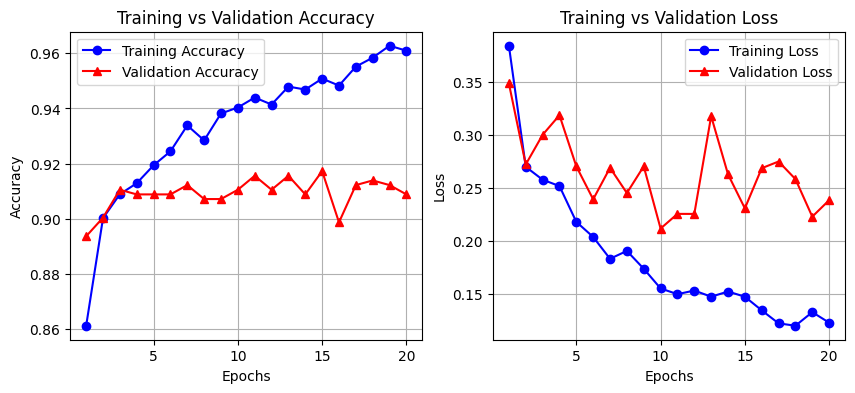

In [6]:
import matplotlib.pyplot as plt
import pickle

# Load training history
with open("train_history.pkl", "rb") as f:
    history = pickle.load(f)

# Extract metrics
train_acc = history["accuracy"]
val_acc = history["val_accuracy"]
train_loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, "bo-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r^-", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "r^-", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()

plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


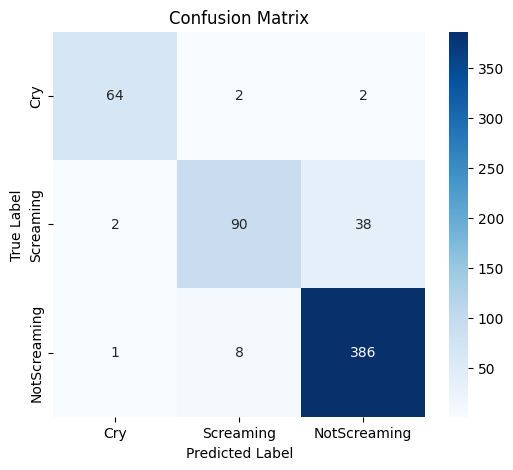

In [8]:
# Plot Confusion Matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load test data
with open("train_valid_test.pkl", "rb") as f:
    data_splits = pickle.load(f)
    
X_test, y_test = data_splits["test"]

# Load trained model
model = tf.keras.models.load_model("yamnet_finetuned.h5")

# Predict on test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_MAPPING.keys(), yticklabels=CLASS_MAPPING.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


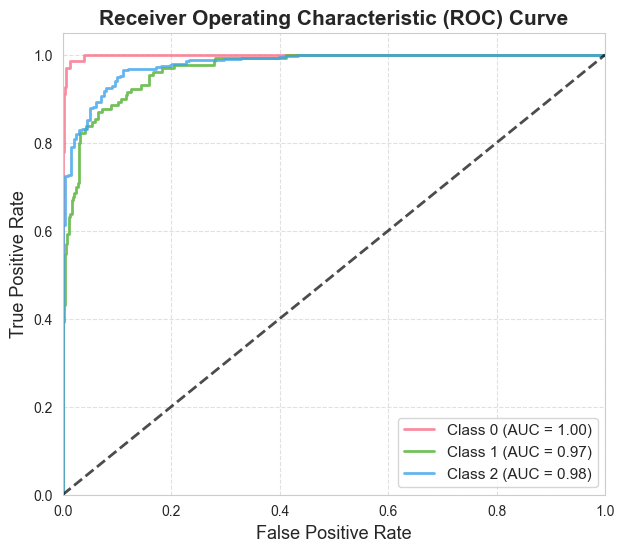

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
import pickle
import tensorflow as tf

# Load test data
with open("train_valid_test.pkl", "rb") as f:
    data_splits = pickle.load(f)
X_test, y_test = data_splits["test"]

# Load trained model
model = tf.keras.models.load_model("yamnet_finetuned.h5")

# Predict on test set
y_pred = model.predict(X_test)

# One-hot encode true labels
enc = OneHotEncoder()
y_true = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

NUM_CLASSES = y_true.shape[1]  # Ensure we get the correct number of classes

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Set Seaborn style
sns.set_style("whitegrid")

# Create a new figure
plt.figure(figsize=(7, 6))

# Define a color palette
colors = sns.color_palette("husl", NUM_CLASSES)

# Plot ROC curve for each class
for i, color in enumerate(colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2, alpha=0.8,
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})"
    )

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], "k--", lw=2, alpha=0.7)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=15, fontweight="bold")
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


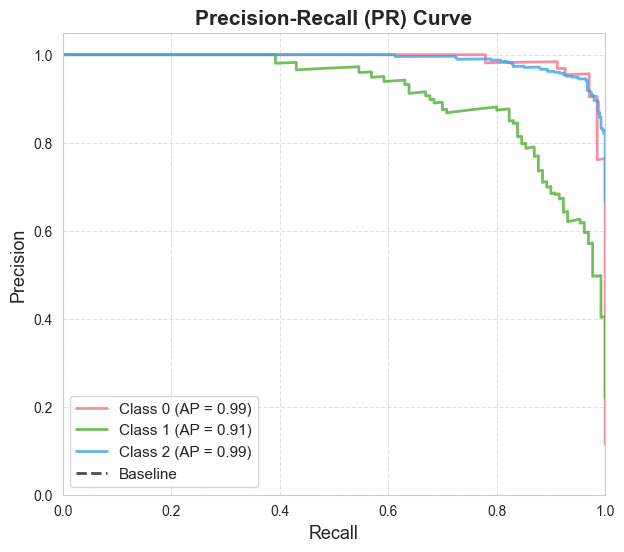

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import OneHotEncoder
import pickle
import tensorflow as tf

# Load test data
with open("train_valid_test.pkl", "rb") as f:
    data_splits = pickle.load(f)
X_test, y_test = data_splits["test"]

# Load trained model
model = tf.keras.models.load_model("yamnet_finetuned.h5")

# Predict on test set
y_pred = model.predict(X_test)

# One-hot encode true labels
enc = OneHotEncoder()
y_true = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

NUM_CLASSES = y_true.shape[1]  # Get the correct number of classes

# Compute PR curve and Average Precision for each class
precision, recall, average_precision = {}, {}, {}

for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# Set Seaborn style
sns.set_style("whitegrid")

# Create a new figure
plt.figure(figsize=(7, 6))

# Define a color palette
colors = sns.color_palette("husl", NUM_CLASSES)

# Plot PR curve for each class
for i, color in enumerate(colors):
    plt.plot(
        recall[i], precision[i], color=color, lw=2, alpha=0.8,
        label=f"Class {i} (AP = {average_precision[i]:.2f})"
    )

# Plot baseline (random classifier) at y = ratio of positive samples
baseline = np.mean(y_test)
plt.plot([0, 1], [baseline, baseline], "k--", lw=2, alpha=0.7, label="Baseline")

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Precision-Recall (PR) Curve", fontsize=15, fontweight="bold")
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [4]:
# Test our trained model on random audio file
filename = "Datasets/Cry/0c8f14a9-6999-485b-97a2-913c1cbf099c-1430760379259-1.7-m-26-hu.wav"
embedding = extract_embedding(filename)
embedding = np.expand_dims(embedding, axis=0)
prediction = model.predict(embedding)
predicted_class = np.argmax(prediction)

# Load class mapping
CLASS_MAPPING = {0: "Cry", 1: "Screaming", 2: "NotScreaming"}

print(f"Predicted Class: {CLASS_MAPPING[predicted_class]}")
print(f"Prediction Scores: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: Cry
Prediction Scores: [9.9248135e-01 7.2007808e-03 3.1792070e-04]


Sum of Probabilities: 1.0
